# Hayden French (hmf9kx) DS 5001 Final Project Code

## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import re
import nltk
from nltk.stem.porter import PorterStemmer
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA as sk_learn_PCA
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE as tsne
from gensim.models import word2vec
from gensim.corpora import Dictionary

## Helper Functions

In [2]:
def script_to_LINES(script, replace_dict={}, drop_words={}):
    LINES = pd.DataFrame(script, columns=['line_str'])
    LINES.index.name = 'line_num'
    LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip() # Replace newlines
    LINES = LINES[LINES['line_str'].str.strip().str.len() > 0] # Drop empty strings
    
    LINES.line_str = LINES.line_str.replace(replace_dict, regex=True) # Replace select words
    LINES = LINES[~LINES['line_str'].isin(drop_words)] # Drop select columns
    
    LINES = LINES.reset_index(drop=True)
    
    return LINES

In [3]:
def assign_page_numbers(lines, page_pat):
    page_number = 1
    page_numbers = []

    for line in lines:
        if re.match(page_pat, line):
            page_number += 1
        page_numbers.append(page_number)

    return page_numbers

In [4]:
def LINES_to_PAGES(LINES, page_pat):
    LINES["page_num"] = assign_page_numbers(LINES.line_str, page_pat)
    LINES = LINES[~LINES['line_str'].str.contains(page_pat, 
                                                  regex=True)].reset_index(drop=True) # Drop lines of just page #
    PAGES = LINES.groupby('page_num')['line_str'].agg(' '.join).reset_index()
    PAGES = PAGES.set_index('page_num')
    return PAGES

In [5]:
def PAGES_to_SENTS(PAGES, sent_pat=r'(?<![MmDd]r)(?<![MmDd]rs)[.?!;:]'):
    SENTS = PAGES['line_str'].str.split(sent_pat, expand=True).stack().to_frame('sent_str')
    SENTS.index.names = ['page_num', 'sent_num']

    SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Drop only whitespace sents
    SENTS.sent_str = SENTS.sent_str.str.strip()
    return SENTS

In [6]:
def SENTS_to_TOKENS(SENTS, token_pat=r"[\s',-]+"):
    TOKENS = SENTS.sent_str.apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack().to_frame('pos_tuple')
    TOKENS.index.names = ['page_num', 'sent_num', 'token_num']
    TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
    TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])
    TOKENS['term_str'] = TOKENS.token_str.str.lower().str.replace(r"\W+", "", regex=True)
    TOKENS['pos_group'] = TOKENS.pos.str[:2]
    
    TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower().str.strip() # Remove non-words
    return TOKENS

## Data Parsing

In [7]:
data_dict = {
    101: {
        'name': 'mariachiel',
        'title': 'El Mariachi',
        'genre': 'Western',
        'path': './Data/Western/mariachiel.txt',
        'replace_dict': {
            'V.O.': 'VOICEOVER', 
            'INT.': 'INTERIOR, ', 
            'EXT.': 'EXTERIOR, '
        },
        'drop_words': ['CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\s*\d+\.\s*$'
    },
    102: {
        'name': 'truegrit',
        'title': 'True Grit',
        'genre': 'Western',
        'path': './Data/Western/truegrit.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'\b\d{1,3}\b'
    },
    103: {
        'name': 'wildwildwest',
        'title': 'Wild Wild West',
        'genre': 'Western',
        'path': './Data/Western/wildwildwest.txt',
        'replace_dict': {r'^\d+\s+CONTINUED$', ''},
        'drop_words': ['CONTINUED', 'CONTINUED:', '(CONTINUED)', 'ILD WILD WEST - Rev. 4/9/97'],
        'page_pat': r'^.*\d+\.$'
    },
    104: {
        'name': 'bookofelithe',
        'title': 'The Book of Eli',
        'genre': 'Western',
        'path': './Data/Western/bookofelithe.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'^.*\d+\.$'
    },
    201: {
        'name': 'bladerunner',
        'title': 'Blade Runner',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/bladerunner.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'.*\d+$'
    },    
    202: {
        'name': 'minorityreport',
        'title': 'Minority Report',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/minorityreport.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': ['-----------------------------------------------------------------------------------------------------'],
        'page_pat': r'^.*\d+\.$'
    },    
    203: {
        'name': 'starshiptroopers',
        'title': 'Starship Troopers',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/starshiptroopers.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+\s'
    },
    204: {
        'name': 'starwarsreturnofthejedi',
        'title': 'Star Wars: Return of the Jedi',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/starwarsreturnofthejedi.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+\s'
    },
    205 : {
        'name': 'totalrecall',
        'title': 'Total Recall',
        'genre': 'Sci-Fi',
        'path': './Data/Sci-Fi/totalrecall.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+.*'
    },
    301: {
        'name': 'dayofthedead',
        'title': 'Day of the Dead',
        'genre': 'Horror',
        'path': './Data/Horror/dayofthedead.txt',
        'replace_dict': {},
        'drop_words': [],
        'page_pat': r'^\d+'
    },
    302: {
        'name': 'evildead',
        'title': 'Evil Dead',
        'genre': 'Horror',
        'path': './Data/Horror/evildead.txt',
        'replace_dict': {'^[IE][NTD] -.*$': ''},
        'drop_words': [],
        'page_pat': r'^\d+$'
    },
    303: {
        'name': 'fridaythe13th',
        'title': 'Friday the 13th',
        'genre': 'Horror',
        'path': './Data/Horror/fridaythe13th.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'\d+\s+.*$'
    },
    304: {
        'name': 'insidious',
        'title': 'Insidious',
        'genre': 'Horror',
        'path': './Data/Horror/insidious.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': [],
        'page_pat': r'^\d+\.$'
    },
    305: {
        'name': 'tremors',
        'title': 'Tremors',
        'genre': 'Horror',
        'path': './Data/Horror/tremors.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+.*\d+$'
    },
    401: {
        'name': '500daysofsummer',
        'title': '500 Days of Summer',
        'genre': 'Comedy',
        'path': './Data/Comedy/500daysofsummer.txt',
        'replace_dict': {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'EXT.': 'EXTERIOR, '},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    402: {
        'name': 'analyzethat',
        'title': 'Analyze That',
        'genre': 'Comedy',
        'path': './Data/Comedy/analyzethat.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    403: {
        'name': 'deathtosmoochy',
        'title': 'Death To Smoochy',
        'genre': 'Comedy',
        'path': './Data/Comedy/deathtosmoochy.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:', 'CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\d+\.$'
    },
    404: {
        'name': 'dumbanddumber',
        'title': 'Dumb and Dumber',
        'genre': 'Comedy',
        'path': './Data/Comedy/dumbanddumber.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    405: {
        'name': 'shesoutofmyleague',
        'title': "She's Out of My League",
        'genre': 'Comedy',
        'path': './Data/Comedy/shesoutofmyleague.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    501: {
        'name': 'amour',
        'title': 'Amour',
        'genre': 'Romance',
        'path': './Data/Romance/amour.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    502: {
        'name': 'angeleyes',
        'title': 'Angel Eyes',
        'genre': 'Romance',
        'path': './Data/Romance/angeleyes.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:', 'CONTINUED', 'CONTINUED:', '(CONTINUED)'],
        'page_pat': r'^\d+\.$'
    },
    503: {
        'name': 'crazylove',
        'title': 'Crazy Love',
        'genre': 'Romance',
        'path': './Data/Romance/crazylove.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    504: {
        'name': 'faultinourstarsthe',
        'title': 'The Fault in Our Stars',
        'genre': 'Romance',
        'path': './Data/Romance/faultinourstarsthe.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    },
    505: {
        'name': 'walktoremembera',
        'title': 'A Walk to Remember',
        'genre': 'Romance',
        'path': './Data/Romance/walktoremembera.txt',
        'replace_dict': {'V.O.': 'VOICEOVER'},
        'drop_words': ['CUT TO', 'CUT TO:'],
        'page_pat': r'^\d+\.$'
    }
}

## LIB

In [8]:
LIB = pd.DataFrame(data_dict).T
LIB

name                          title    genre  \
101               mariachiel                    El Mariachi  Western   
102                 truegrit                      True Grit  Western   
103             wildwildwest                 Wild Wild West  Western   
104             bookofelithe                The Book of Eli  Western   
201              bladerunner                   Blade Runner   Sci-Fi   
202           minorityreport                Minority Report   Sci-Fi   
203         starshiptroopers              Starship Troopers   Sci-Fi   
204  starwarsreturnofthejedi  Star Wars: Return of the Jedi   Sci-Fi   
205              totalrecall                   Total Recall   Sci-Fi   
301             dayofthedead                Day of the Dead   Horror   
302                 evildead                      Evil Dead   Horror   
303            fridaythe13th                Friday the 13th   Horror   
304                insidious                      Insidious   Horror   
305                  tremors                        Tremors   Horror   
401          500daysofsummer             500 Days of Summer   Comedy   
402              analyzethat                   Analyze That   Comedy   
403           deathtosmoochy               Death To Smoochy   Comedy   
404            dumbanddumber                Dumb and Dumber   Comedy   
405        shesoutofmyleague         She's Out of My League   Comedy   
501                    amour                          Amour  Romance   
502                angeleyes                     Angel Eyes  Romance   
503                crazylove                     Crazy Love  Romance   
504       faultinourstarsthe         The Fault in Our Stars  Romance   
505          walktoremembera             A Walk to Remember  Romance   

                                          path  \
101              ./Data/Western/mariachiel.txt   
102                ./Data/Western/truegrit.txt   
103            ./Data/Western/wildwildwest.txt   
104            ./Data/Western/bookofelithe.txt   
201              ./Data/Sci-Fi/bladerunner.txt   
202           ./Data/Sci-Fi/minorityreport.txt   
203         ./Data/Sci-Fi/starshiptroopers.txt   
204  ./Data/Sci-Fi/starwarsreturnofthejedi.txt   
205              ./Data/Sci-Fi/totalrecall.txt   
301             ./Data/Horror/dayofthedead.txt   
302                 ./Data/Horror/evildead.txt   
303            ./Data/Horror/fridaythe13th.txt   
304                ./Data/Horror/insidious.txt   
305                  ./Data/Horror/tremors.txt   
401          ./Data/Comedy/500daysofsummer.txt   
402              ./Data/Comedy/analyzethat.txt   
403           ./Data/Comedy/deathtosmoochy.txt   
404            ./Data/Comedy/dumbanddumber.txt   
405        ./Data/Comedy/shesoutofmyleague.txt   
501                   ./Data/Romance/amour.txt   
502               ./Data/Romance/angeleyes.txt   
503               ./Data/Romance/crazylove.txt   
504      ./Data/Romance/faultinourstarsthe.txt   
505         ./Data/Romance/walktoremembera.txt   

                                          replace_dict  \
101  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
102                                                 {}   
103                              {, ^\d+\s+CONTINUED$}   
104  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
201  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
202  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
203                                                 {}   
204                                                 {}   
205                                                 {}   
301                                                 {}   
302                            {'^[IE][NTD] -.*$': ''}   
303                              {'V.O.': 'VOICEOVER'}   
304  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
305                              {'V.O.': 'VOICEOVER'}   
401  {'V.O.': 'VOICEOVER', 'INT.': 'INTERIOR, ', 'E...   
402                              {'V.O.': 'V

## CORPUS

In [9]:
def id_to_TOKENS(script_id):
    id_data = LIB.loc[script_id]
    path = id_data.path
    script = open(path, 'r').readlines()
    LINES = script_to_LINES(script, replace_dict=id_data.replace_dict, drop_words=id_data.drop_words)
    PAGES = LINES_to_PAGES(LINES, id_data.page_pat)
    SENTS = PAGES_to_SENTS(PAGES)
    TOKENS = SENTS_to_TOKENS(SENTS).reset_index()
    TOKENS['script_id'] = script_id

    TOKENS.set_index(['script_id', 'page_num', 'sent_num', 'token_num'], inplace=True)
    return TOKENS

In [10]:
def LIB_to_CORPUS(LIB):
    CORPUS = pd.DataFrame()
    for script_id in LIB.index:
        CORPUS = pd.concat([CORPUS, id_to_TOKENS(script_id)])
    return CORPUS

In [11]:
CORPUS = LIB_to_CORPUS(LIB)

In [12]:
CORPUS

pos_tuple  pos token_str  \
script_id page_num sent_num token_num                                   
101       1        0        0               (FADE, NN)   NN      FADE   
                            1                (IN, NNP)  NNP        IN   
                   1        0          (EXTERIOR, NNP)  NNP  EXTERIOR   
                            1                   (,, ,)    ,         ,   
                            2                 (A, NNP)  NNP         A   
...                                                ...  ...       ...   
505       122      8        2              (there, RB)   RB     there   
                   11       0               (FADE, CD)   CD      FADE   
                            1                (OUT, RP)   RP       OUT   
                   12       0                (THE, DT)   DT       THE   
                            1                (END, NN)   NN       END   

                                       term_str pos_group  
script_id page_num sent_num token_num                      
101       1        0        0              fade        NN  
                            1                in        NN  
                   1        0          exterior        NN  
                            1                           ,  
                            2                 a        NN  
...                                         ...       ...  
505       122      8        2             there        RB  
                   11       0              fade        CD  
                            1               out        RP  
                   12       0               the        DT  
                            1               end        NN  

[574748 rows x 5 columns]

## VOCAB

In [13]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB

n         p          i  n_chars
term_str                                      
           40003  0.069601   3.844749        0
the        28031  0.048771   4.357834        3
a          13083  0.022763   5.457164        1
and        11878  0.020666   5.596566        3
to         11357  0.019760   5.661276        2
...          ...       ...        ...      ...
narrative      1  0.000002  19.132570        9
solace         1  0.000002  19.132570        6
highborn       1  0.000002  19.132570        8
lineage        1  0.000002  19.132570        7
marrying       1  0.000002  19.132570        8

[22217 rows x 4 columns]

In [14]:
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['p_stem'] = VOCAB.apply(lambda x: PorterStemmer().stem(x.name), 1)

In [15]:
sw = pd.DataFrame({'stop': 1}, index=nltk.corpus.stopwords.words('english'))
sw.index.name='term_str'

if 'stop' not in VOCAB.columns:
    VOCAB = VOCAB.join(sw)
    VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [16]:
OHCO = ['script_id', 'page_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:3],
    PAGES = OHCO[:2],
    SCRIPTS = OHCO[:1]
)

In [17]:
def gen_BOW(token_df, bag): # Bag parameter is one of 'SENTS', 'PARAS', 'CHAPS', or 'BOOKS'
    return token_df.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n') 

In [18]:
def BOW_to_TFIDF(BOW, tf_method): # tf_method is 'sum', 'max', 'log', 'raw', 'double_norm', 'binary', or 'df'
    DTCM = BOW.n.unstack(fill_value=0)
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)

    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    
    if tf_method == 'df':
        return DF * IDF
    
    TF = TF.T
    TFIDF = TF * IDF
    
    return TFIDF

In [19]:
BOW = gen_BOW(CORPUS, "PAGES")
DFIDF = BOW_to_TFIDF(BOW, 'df')

In [20]:
VOCAB = pd.merge(VOCAB, pd.DataFrame(DFIDF), left_index=True, right_index=True, 
         how='inner').rename(columns={0: "DFIDF"})
VOCAB.head(5)

n         p         i  n_chars max_pos_group max_pos p_stem  \
term_str                                                                    
          40003  0.069601  3.844749        0             ,       ,          
the       28031  0.048771  4.357834        3            DT      DT    the   
a         13083  0.022763  5.457164        1            DT      DT      a   
and       11878  0.020666  5.596566        3            CC      CC    and   
to        11357  0.019760  5.661276        2            TO      TO     to   

          stop       DFIDF  
term_str                    
             0  210.833657  
the          1  109.631920  
a            1  488.979512  
and          1  459.973565  
to           1  544.879535

In [21]:
VOCAB.sort_values('DFIDF', ascending=False).head(20).index

Index(['down', 'not', 'me', 'into', 'have', 'there', 'back', 'be', 'they',
       'just', 're', 'looks', 'like', 'one', 'no', 'all', 'then', 'she', 'him',
       'but'],
      dtype='object', name='term_str')

## BOW

In [22]:
TFIDF = BOW_to_TFIDF(BOW, 'max')

In [23]:
BOW['tfidf'] = TFIDF.stack()
BOW

n     tfidf
script_id page_num term_str               
101       1                   27  0.074923
                   a          23  0.160084
                   across      1  0.124017
                   admiring    1  0.353086
                   alonside    1  0.427160
...                           ..       ...
505       122      the         2  0.037974
                   there       1  0.774456
                   things      1  2.074813
                   voiceover   1  2.278025
                   you         2  0.543935

[321665 rows x 2 columns]

## DTCM

In [24]:
DTCM = BOW.n.unstack(fill_value=0)
DTCM

term_str                0  00  01  0256  03  0300  05  06  07  ...  zone  \
script_id page_num                                             ...         
101       1         27  0   0   0     0   0     0   0   0   0  ...     0   
          2         30  0   0   0     0   0     0   0   0   0  ...     0   
          3         25  0   0   0     0   0     0   0   0   0  ...     0   
          4         32  0   0   0     0   0     0   0   0   0  ...     0   
          5         25  0   0   0     0   0     0   0   0   0  ...     0   
...                 .. ..  ..  ..   ...  ..   ...  ..  ..  ..  ...   ...   
505       118       24  0   0   0     0   0     0   0   0   0  ...     0   
          119       18  0   0   0     0   0     0   0   0   0  ...     0   
          120       23  0   0   0     0   0     0   0   0   0  ...     0   
          121       14  0   0   0     0   0     0   0   0   0  ...     0   
          122        2  0   0   0     0   0     0   0   0   0  ...     0   

term_str            zoned  zoners  zones  zoo  zoological  zoom  zoomed  \
script_id page_num                                                        
101       1             0       0      0    0           0     0       0   
          2             0       0      0    0           0     0       0   
          3             0       0      0    0           0     0       0   
          4             0       0      0    0           0     0       0   
          5             0       0      0    0           0     0       0   
...                   ...     ...    ...  ...         ...   ...     ...   
505       118           0       0      0    0           0     0       0   
          119           0       0      0    0           0     0       0   
          120           0       0      0    0           0     0       0   
          121           0       0      0    0           0     0       0   
          122           0       0      0    0           0     0       0   

term_str            zooms  zwei  
script_id page_num               
101       1             0     0  
          2             0     0  
          3             0     0  
          4             0     0  
          5             0     0  
...                   ...   ...  
505       118           0     0  
          119           0     0  
          120           0     0  
          121           0     0  
          122           0     0  

[2964 rows x 22217 columns]

## TFIDF

In [25]:
TFIDF.mean().sort_values(ascending=False).head(20)

term_str
letty      0.125429
i          0.116773
you        0.108006
tom        0.103722
her        0.102465
hazel      0.099096
she        0.098908
landon     0.093376
kirk       0.089668
he         0.089448
his        0.079736
johnny     0.079359
quail      0.077629
michael    0.077045
we         0.075103
nt         0.071996
they       0.070193
lloyd      0.070160
it         0.069996
do         0.069588
dtype: float64

In [26]:
TFIDF_L2 = TFIDF.apply(lambda x: x / np.linalg.norm(x), axis=1)

In [27]:
TFIDF_L2.mean().sort_values(ascending=False).head(20)

term_str
i         0.019384
letty     0.017906
you       0.017617
tom       0.017458
her       0.017386
hazel     0.017217
she       0.017071
landon    0.016746
he        0.015233
sharon    0.013432
his       0.013423
kirk      0.013372
we        0.012331
lloyd     0.012047
nt        0.011925
vitti     0.011642
it        0.011642
harry     0.011550
they      0.011533
do        0.011477
dtype: float64

In [28]:
LIB.reset_index(inplace=True)
LIB.rename(columns={'index': 'script_id'}, inplace=True)

top_1000_nouns = VOCAB[VOCAB.max_pos.isin(['NN', 'NNS'])].sort_values('DFIDF', ascending=False).head(1000).index
TFIDF_reduced = TFIDF_L2[top_1000_nouns]

In [29]:
TFIDF_reduced

term_str              look      door      room      head  time       int  \
script_id page_num                                                         
101       1         0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          2         0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          3         0.0000  0.039920  0.000000  0.000000   0.0  0.000000   
          4         0.0000  0.030935  0.000000  0.000000   0.0  0.000000   
          5         0.0000  0.000000  0.000000  0.016073   0.0  0.000000   
...                    ...       ...       ...       ...   ...       ...   
505       118       0.0235  0.000000  0.000000  0.000000   0.0  0.025483   
          119       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          120       0.0000  0.000000  0.030733  0.000000   0.0  0.000000   
          121       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   
          122       0.0000  0.000000  0.000000  0.000000   0.0  0.000000   

term_str                eyes       man      hand       way  ...  fists  \
script_id page_num                                          ...          
101       1         0.000000  0.000000  0.000000  0.000000  ...    0.0   
          2         0.000000  0.000000  0.026528  0.000000  ...    0.0   
          3         0.000000  0.000000  0.000000  0.000000  ...    0.0   
          4         0.000000  0.017025  0.017214  0.000000  ...    0.0   
          5         0.000000  0.000000  0.016972  0.000000  ...    0.0   
...                      ...       ...       ...       ...  ...    ...   
505       118       0.025959  0.000000  0.000000  0.026896  ...    0.0   
          119       0.000000  0.000000  0.102411  0.000000  ...    0.0   
          120       0.000000  0.032888  0.000000  0.000000  ...    0.0   
          121       0.000000  0.028531  0.000000  0.000000  ...    0.0   
          122       0.124090  0.000000  0.000000  0.000000  ...    0.0   

term_str            ticket  unsure  cups  curtains  cloth  shriek  gunfire  \
script_id page_num                                                           
101       1            0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          2            0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          3            0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          4            0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          5            0.0     0.0   0.0       0.0    0.0     0.0      0.0   
...                    ...     ...   ...       ...    ...     ...      ...   
505       118          0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          119          0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          120          0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          121          0.0     0.0   0.0       0.0    0.0     0.0      0.0   
          122          0.0     0.0   0.0       0.0    0.0     0.0      0.0   

term_str            manner  training  
script_id page_num                    
101       1            0.0       0.0  
          2            0.0       0.0  
          3            0.0       0.0  
          4            0.0       0.0  
          5            0.0       0.0  
...                    ...       ...  
505       118          0.0       0.0  
          119          0.0       0.0  
          120          0.0       0.0  
          121          0.0       0.0  
          122          0.0       0.0  

[2964 rows x 1000 columns]

## PCA

In [30]:
def PCA(X, k, norm_docs, center_by_mean, center_by_variance):
    if norm_docs:
        X = (X.T / norm(X, 2, axis=1)).T # L2 norm
    X = X.dropna()
    if center_by_mean:
        X = X - X.mean() # Center term vectors by mean
    elif center_by_variance:
        X = X / X.std() # Center term vectors by std
    COV = X.cov()
    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'
    
    DCM = X.dot(COMPS[COV.index].T) 
    
    return LOADINGS, DCM, COMPS

In [31]:
L, D, C = PCA(X=TFIDF_reduced, k=10, norm_docs=True, center_by_mean=False, center_by_variance=False)

In [32]:
D = pd.merge(D, LIB[['script_id', 'title', 'genre']], on='script_id', 
               how='left')

In [33]:
L['PC0'].sort_values(ascending=False).head(5)

term_str
mrs     0.539314
door    0.294454
room    0.268086
int     0.209781
dr      0.189123
Name: PC0, dtype: float64

In [34]:
L['PC1'].sort_values().head(5)

term_str
mrs      -0.683853
mother   -0.096930
truck    -0.051715
group    -0.049466
bug      -0.048878
Name: PC1, dtype: float64

In [35]:
def vis_pcs(M, a, b, label='genre', hover_name='title', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

In [36]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = L.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos_group', 
                      marginal_x='box', height=800)

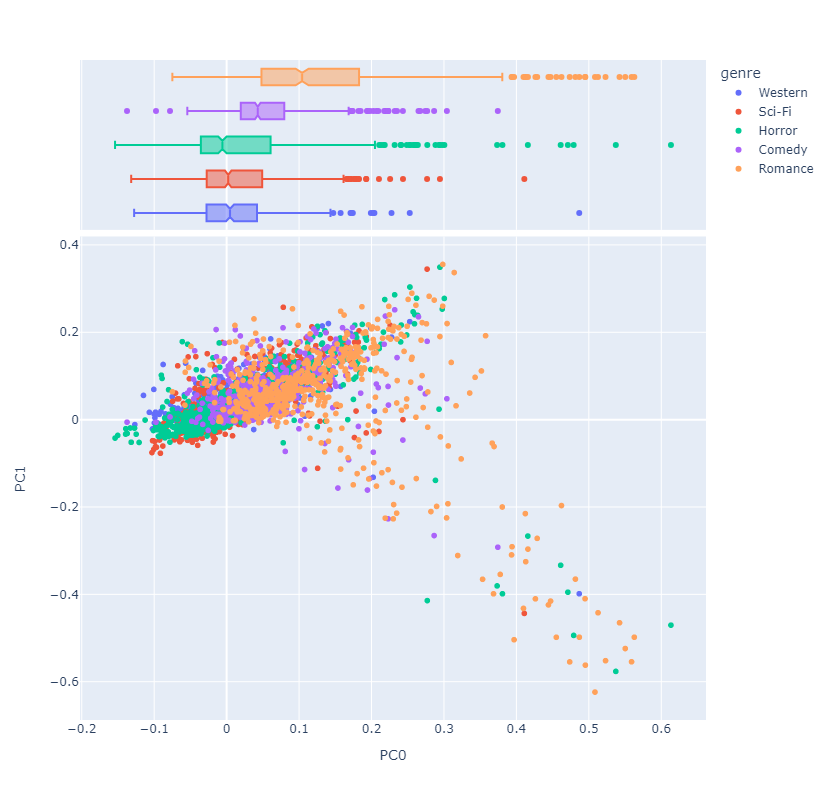

In [37]:
vis_pcs(D, 0, 1)

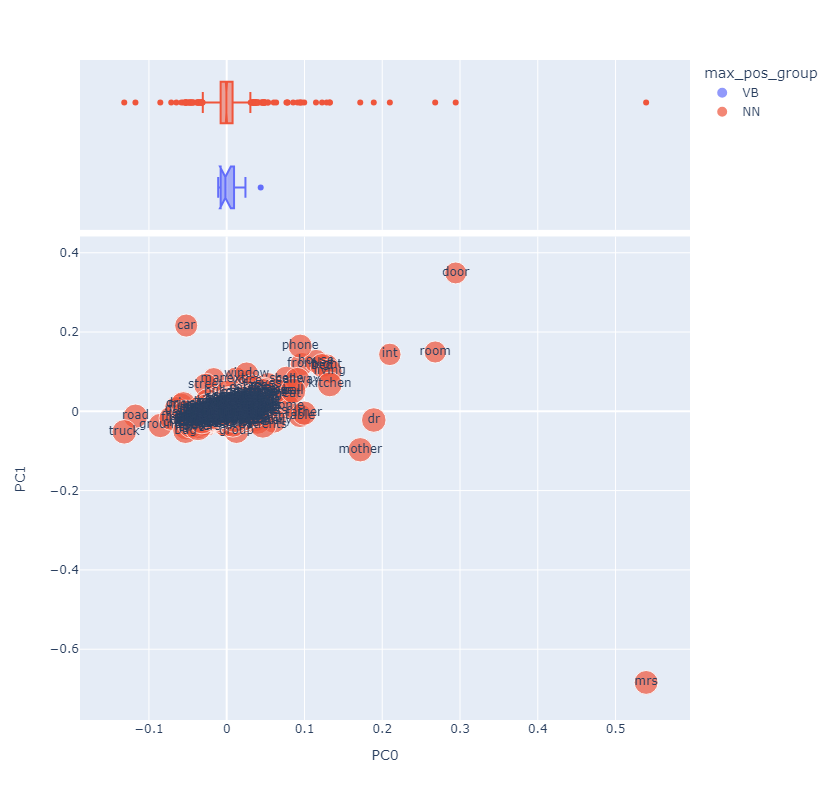

In [38]:
vis_loadings(0, 1)

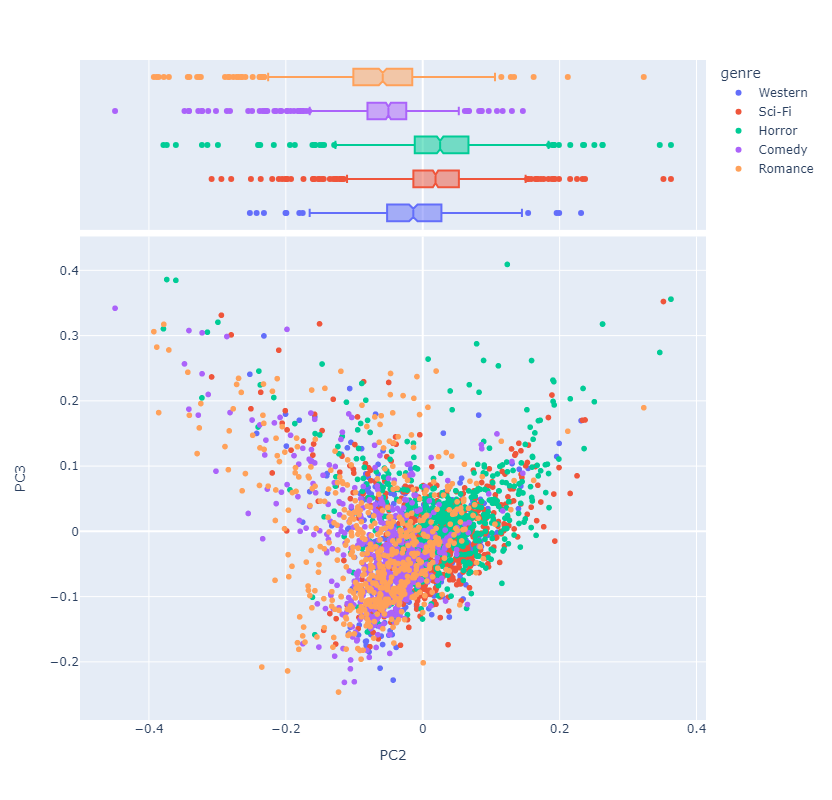

In [39]:
vis_pcs(D, 2, 3)

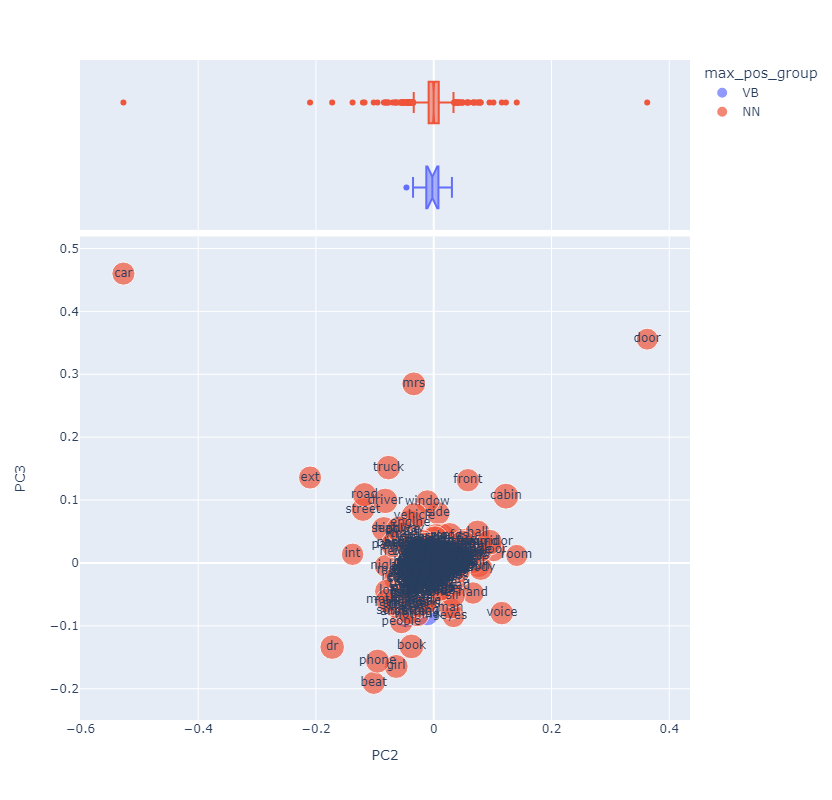

In [40]:
vis_loadings(2, 3)

## LDA

In [41]:
DOC = pd.merge(CORPUS.reset_index(), LIB[['script_id', 'title', 'genre']], on='script_id', how='left')
DOC

script_id  page_num  sent_num  token_num        pos_tuple  pos  \
0             101         1         0          0       (FADE, NN)   NN   
1             101         1         0          1        (IN, NNP)  NNP   
2             101         1         1          0  (EXTERIOR, NNP)  NNP   
3             101         1         1          1           (,, ,)    ,   
4             101         1         1          2         (A, NNP)  NNP   
...           ...       ...       ...        ...              ...  ...   
574743        505       122         8          2      (there, RB)   RB   
574744        505       122        11          0       (FADE, CD)   CD   
574745        505       122        11          1        (OUT, RP)   RP   
574746        505       122        12          0        (THE, DT)   DT   
574747        505       122        12          1        (END, NN)   NN   

       token_str  term_str pos_group               title    genre  
0           FADE      fade        NN         El Mariachi  Western  
1             IN        in        NN         El Mariachi  Western  
2       EXTERIOR  exterior        NN         El Mariachi  Western  
3              ,                   ,         El Mariachi  Western  
4              A         a        NN         El Mariachi  Western  
...          ...       ...       ...                 ...      ...  
574743     there     there        RB  A Walk to Remember  Romance  
574744      FADE      fade        CD  A Walk to Remember  Romance  
574745       OUT       out        RP  A Walk to Remember  Romance  
574746       THE       the        DT  A Walk to Remember  Romance  
574747       END       end        NN  A Walk to Remember  Romance  

[574748 rows x 11 columns]

In [42]:
DOCS = DOC[DOC.pos.str.match(r'^NNS?$')]\
    .groupby(['script_id', 'page_num']).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [43]:
DOCS

doc_str
script_id page_num                                                   
101       1         fade morning patrol car road parks police car ...
          2         phone rings one watch phone cell block someone...
          3         phone friend people days window sound truck ra...
          4         walk guard hand wad money money partner block ...
          5         phone friends something cellmates cell men dea...
...                                                               ...
505       118       ext sea pink purple blossoms dogwoods wisteria...
          119       kneels height chair pause kneels solidarity so...
          120       rev s kind offense pleasure people sins deligh...
          121       wedding ring pause searches something everythi...
          122                                 mystery things eyes end

[2954 rows x 1 columns]

In [44]:
count_engine = CountVectorizer(max_features=4000, ngram_range=(1, 2), stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

lda_engine = LDA(n_components=20, max_iter=5, learning_offset=50., random_state=0)

TNAMES = [f"T{str(x).zfill(len(str(20)))}" for x in range(20)]

lda_model = lda_engine.fit_transform(count_model)

In [45]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [46]:
THETA.sample(10).T.style.background_gradient(cmap="YlGnBu", axis=None)

In [47]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [48]:
PHI.T.sample(10).style.background_gradient(cmap="YlGnBu", axis=None)

In [49]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(5).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

TOPICS.sort_values('doc_weight_sum', ascending=False)

top_terms  doc_weight_sum  term_freq
topic_id                                                        
T11            door room dr face hand      213.609363   0.075688
T14             ext way door gun beat      189.807485   0.065394
T15            car ext man int street      186.736887   0.059881
T06           door int room night bed      166.742714   0.057227
T09         room int table people way      166.493867   0.050323
T10       man head truck way creature      163.389807   0.067869
T17        eyes face head time moment      155.984480   0.053827
T18         hand door book father man      155.345457   0.050293
T08           phone room head bed int      153.754400   0.052226
T13             bug man way bugs eyes      144.487006   0.050094
T03        mrs table people door room      144.390023   0.050301
T16        door window eyes room hand      143.635557   0.050928
T02        hand head door guards deck      142.106744   0.050308
T04            int eyes man ext night      132.096139   0.042515
T07           room int road door time      126.592069   0.046132
T05          man hand people home int      126.347731   0.038253
T01         eyes man rooster gun body      115.442084   0.038220
T12         time way truck case thing      115.190713   0.037632
T00       eyes head beat truck things      106.828461   0.030210
T19         room hand sir summer door      105.019012   0.032679

## TOPICS

In [50]:
GENRES = LIB.genre.value_counts().index.to_list()

In [51]:
TOPICS[GENRES] = pd.merge(THETA, LIB[['script_id', 'title', 'genre']], on='script_id', 
               how='left').groupby('genre')[TNAMES].mean().T

In [52]:
TOPICS

top_terms  doc_weight_sum  term_freq    Sci-Fi  \
topic_id                                                                     
T00       eyes head beat truck things      106.828461   0.030210  0.038054   
T01         eyes man rooster gun body      115.442084   0.038220  0.052261   
T02        hand head door guards deck      142.106744   0.050308  0.015887   
T03        mrs table people door room      144.390023   0.050301  0.053615   
T04            int eyes man ext night      132.096139   0.042515  0.040509   
T05          man hand people home int      126.347731   0.038253  0.040434   
T06           door int room night bed      166.742714   0.057227  0.040494   
T07           room int road door time      126.592069   0.046132  0.047579   
T08           phone room head bed int      153.754400   0.052226  0.064086   
T09         room int table people way      166.493867   0.050323  0.116218   
T10       man head truck way creature      163.389807   0.067869  0.039650   
T11            door room dr face hand      213.609363   0.075688  0.049764   
T12         time way truck case thing      115.190713   0.037632  0.045642   
T13             bug man way bugs eyes      144.487006   0.050094  0.026177   
T14             ext way door gun beat      189.807485   0.065394  0.108778   
T15            car ext man int street      186.736887   0.059881  0.084990   
T16        door window eyes room hand      143.635557   0.050928  0.023011   
T17        eyes face head time moment      155.984480   0.053827  0.051877   
T18         hand door book father man      155.345457   0.050293  0.033761   
T19         room hand sir summer door      105.019012   0.032679  0.027210   

            Horror    Comedy   Romance   Western  
topic_id                                          
T00       0.051888  0.031957  0.026365  0.030093  
T01       0.026944  0.024999  0.038103  0.061668  
T02       0.041413  0.013306  0.085629  0.087354  
T03       0.036931  0.074943  0.037124  0.047209  
T04       0.027199  0.089878  0.039814  0.026870  
T05       0.033886  0.038692  0.062240  0.032104  
T06       0.083129  0.063443  0.043792  0.047369  
T07       0.043936  0.030262  0.053399  0.032734  
T08       0.042166  0.064865  0.036850  0.060721  
T09       0.033752  0.052976  0.020553  0.076259  
T10       0.106739  0.019475  0.052038  0.046336  
T11       0.065215  0.122411  0.066374  0.058490  
T12       0.036686  0.022947  0.040688  0.052390  
T13       0.051812  0.019268  0.086855  0.050266  
T14       0.029890  0.056944  0.045224  0.101804  
T15       0.053518  0.082310  0.054400  0.037351  
T16       0.095811  0.028434  0.051095  0.029424  
T17       0.052515  0.085616  0.043571  0.025801  
T18       0.046579  0.052183  0.062328  0.073294  
T19       0.039992  0.025093  0.053558  0.022462

In [53]:
TOPICS[GENRES + ['top_terms']].sort_values('Western', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T14       0.108778  0.029890  0.056944  0.045224  0.101804   
T02       0.015887  0.041413  0.013306  0.085629  0.087354   
T09       0.116218  0.033752  0.052976  0.020553  0.076259   
T18       0.033761  0.046579  0.052183  0.062328  0.073294   
T01       0.052261  0.026944  0.024999  0.038103  0.061668   
T08       0.064086  0.042166  0.064865  0.036850  0.060721   
T11       0.049764  0.065215  0.122411  0.066374  0.058490   
T12       0.045642  0.036686  0.022947  0.040688  0.052390   
T13       0.026177  0.051812  0.019268  0.086855  0.050266   
T06       0.040494  0.083129  0.063443  0.043792  0.047369   
T03       0.053615  0.036931  0.074943  0.037124  0.047209   
T10       0.039650  0.106739  0.019475  0.052038  0.046336   
T15       0.084990  0.053518  0.082310  0.054400  0.037351   
T07       0.047579  0.043936  0.030262  0.053399  0.032734   
T05       0.040434  0.033886  0.038692  0.062240  0.032104   
T00       0.038054  0.051888  0.031957  0.026365  0.030093   
T16       0.023011  0.095811  0.028434  0.051095  0.029424   
T04       0.040509  0.027199  0.089878  0.039814  0.026870   
T17       0.051877  0.052515  0.085616  0.043571  0.025801   
T19       0.027210  0.039992  0.025093  0.053558  0.022462   

                            top_terms  
topic_id                               
T14             ext way door gun beat  
T02        hand head door guards deck  
T09         room int table people way  
T18         hand door book father man  
T01         eyes man rooster gun body  
T08           phone room head bed int  
T11            door room dr face hand  
T12         time way truck case thing  
T13             bug man way bugs eyes  
T06           door int room night bed  
T03        mrs table people door room  
T10       man head truck way creature  
T15            car ext man int street  
T07           room int road door time  
T05          man hand people home int  
T00       eyes head beat truck things  
T16        door window eyes room hand  
T04            int eyes man ext night  
T17        eyes face head time moment  
T19         room hand sir summer door

In [54]:
TOPICS[GENRES + ['top_terms']].sort_values('Sci-Fi', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T09       0.116218  0.033752  0.052976  0.020553  0.076259   
T14       0.108778  0.029890  0.056944  0.045224  0.101804   
T15       0.084990  0.053518  0.082310  0.054400  0.037351   
T08       0.064086  0.042166  0.064865  0.036850  0.060721   
T03       0.053615  0.036931  0.074943  0.037124  0.047209   
T01       0.052261  0.026944  0.024999  0.038103  0.061668   
T17       0.051877  0.052515  0.085616  0.043571  0.025801   
T11       0.049764  0.065215  0.122411  0.066374  0.058490   
T07       0.047579  0.043936  0.030262  0.053399  0.032734   
T12       0.045642  0.036686  0.022947  0.040688  0.052390   
T04       0.040509  0.027199  0.089878  0.039814  0.026870   
T06       0.040494  0.083129  0.063443  0.043792  0.047369   
T05       0.040434  0.033886  0.038692  0.062240  0.032104   
T10       0.039650  0.106739  0.019475  0.052038  0.046336   
T00       0.038054  0.051888  0.031957  0.026365  0.030093   
T18       0.033761  0.046579  0.052183  0.062328  0.073294   
T19       0.027210  0.039992  0.025093  0.053558  0.022462   
T13       0.026177  0.051812  0.019268  0.086855  0.050266   
T16       0.023011  0.095811  0.028434  0.051095  0.029424   
T02       0.015887  0.041413  0.013306  0.085629  0.087354   

                            top_terms  
topic_id                               
T09         room int table people way  
T14             ext way door gun beat  
T15            car ext man int street  
T08           phone room head bed int  
T03        mrs table people door room  
T01         eyes man rooster gun body  
T17        eyes face head time moment  
T11            door room dr face hand  
T07           room int road door time  
T12         time way truck case thing  
T04            int eyes man ext night  
T06           door int room night bed  
T05          man hand people home int  
T10       man head truck way creature  
T00       eyes head beat truck things  
T18         hand door book father man  
T19         room hand sir summer door  
T13             bug man way bugs eyes  
T16        door window eyes room hand  
T02        hand head door guards deck

In [55]:
TOPICS[GENRES + ['top_terms']].sort_values('Horror', ascending=False)

Sci-Fi    Horror    Comedy   Romance   Western  \
topic_id                                                     
T10       0.039650  0.106739  0.019475  0.052038  0.046336   
T16       0.023011  0.095811  0.028434  0.051095  0.029424   
T06       0.040494  0.083129  0.063443  0.043792  0.047369   
T11       0.049764  0.065215  0.122411  0.066374  0.058490   
T15       0.084990  0.053518  0.082310  0.054400  0.037351   
T17       0.051877  0.052515  0.085616  0.043571  0.025801   
T00       0.038054  0.051888  0.031957  0.026365  0.030093   
T13       0.026177  0.051812  0.019268  0.086855  0.050266   
T18       0.033761  0.046579  0.052183  0.062328  0.073294   
T07       0.047579  0.043936  0.030262  0.053399  0.032734   
T08       0.064086  0.042166  0.064865  0.036850  0.060721   
T02       0.015887  0.041413  0.013306  0.085629  0.087354   
T19       0.027210  0.039992  0.025093  0.053558  0.022462   
T03       0.053615  0.036931  0.074943  0.037124  0.047209   
T12       0.045642  0.036686  0.022947  0.040688  0.052390   
T05       0.040434  0.033886  0.038692  0.062240  0.032104   
T09       0.116218  0.033752  0.052976  0.020553  0.076259   
T14       0.108778  0.029890  0.056944  0.045224  0.101804   
T04       0.040509  0.027199  0.089878  0.039814  0.026870   
T01       0.052261  0.026944  0.024999  0.038103  0.061668   

                            top_terms  
topic_id                               
T10       man head truck way creature  
T16        door window eyes room hand  
T06           door int room night bed  
T11            door room dr face hand  
T15            car ext man int street  
T17        eyes face head time moment  
T00       eyes head beat truck things  
T13             bug man way bugs eyes  
T18         hand door book father man  
T07           room int road door time  
T08           phone room head bed int  
T02        hand head door guards deck  
T19         room hand sir summer door  
T03        mrs table people door room  
T12         time way truck case thing  
T05          man hand people home int  
T09         room int table people way  
T14             ext way door gun beat  
T04            int eyes man ext night  
T01         eyes man rooster gun body

In [56]:
TOPICS['genre'] = TOPICS[GENRES].idxmax(1)
TOPICS

top_terms  doc_weight_sum  term_freq    Sci-Fi  \
topic_id                                                                     
T00       eyes head beat truck things      106.828461   0.030210  0.038054   
T01         eyes man rooster gun body      115.442084   0.038220  0.052261   
T02        hand head door guards deck      142.106744   0.050308  0.015887   
T03        mrs table people door room      144.390023   0.050301  0.053615   
T04            int eyes man ext night      132.096139   0.042515  0.040509   
T05          man hand people home int      126.347731   0.038253  0.040434   
T06           door int room night bed      166.742714   0.057227  0.040494   
T07           room int road door time      126.592069   0.046132  0.047579   
T08           phone room head bed int      153.754400   0.052226  0.064086   
T09         room int table people way      166.493867   0.050323  0.116218   
T10       man head truck way creature      163.389807   0.067869  0.039650   
T11            door room dr face hand      213.609363   0.075688  0.049764   
T12         time way truck case thing      115.190713   0.037632  0.045642   
T13             bug man way bugs eyes      144.487006   0.050094  0.026177   
T14             ext way door gun beat      189.807485   0.065394  0.108778   
T15            car ext man int street      186.736887   0.059881  0.084990   
T16        door window eyes room hand      143.635557   0.050928  0.023011   
T17        eyes face head time moment      155.984480   0.053827  0.051877   
T18         hand door book father man      155.345457   0.050293  0.033761   
T19         room hand sir summer door      105.019012   0.032679  0.027210   

            Horror    Comedy   Romance   Western    genre  
topic_id                                                   
T00       0.051888  0.031957  0.026365  0.030093   Horror  
T01       0.026944  0.024999  0.038103  0.061668  Western  
T02       0.041413  0.013306  0.085629  0.087354  Western  
T03       0.036931  0.074943  0.037124  0.047209   Comedy  
T04       0.027199  0.089878  0.039814  0.026870   Comedy  
T05       0.033886  0.038692  0.062240  0.032104  Romance  
T06       0.083129  0.063443  0.043792  0.047369   Horror  
T07       0.043936  0.030262  0.053399  0.032734  Romance  
T08       0.042166  0.064865  0.036850  0.060721   Comedy  
T09       0.033752  0.052976  0.020553  0.076259   Sci-Fi  
T10       0.106739  0.019475  0.052038  0.046336   Horror  
T11       0.065215  0.122411  0.066374  0.058490   Comedy  
T12       0.036686  0.022947  0.040688  0.052390  Western  
T13       0.051812  0.019268  0.086855  0.050266  Romance  
T14       0.029890  0.056944  0.045224  0.101804   Sci-Fi  
T15       0.053518  0.082310  0.054400  0.037351   Sci-Fi  
T16       0.095811  0.028434  0.051095  0.029424   Horror  
T17       0.052515  0.085616  0.043571  0.025801   Comedy  
T18       0.046579  0.052183  0.062328  0.073294  Western  
T19       0.039992  0.025093  0.053558  0.022462  Romance

In [57]:
pca_engine_phi = sk_learn_PCA(2)

In [58]:
PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
PHI_COMPS['mean_doc_weight'] = THETA.mean()
PHI_COMPS

0         1  mean_doc_weight
topic_id                                     
T00       0.043519 -0.152262         0.036164
T01      -0.056991 -0.378490         0.039080
T02      -0.181436 -0.171237         0.048107
T03      -0.067541  0.194085         0.048879
T04       0.250679 -0.050451         0.044718
T05      -0.005512  0.037191         0.042772
T06      -0.184955  0.322805         0.056446
T07      -0.057514  0.136757         0.042854
T08       0.151165  0.461743         0.052050
T09       0.054024 -0.030465         0.056362
T10      -0.079090 -0.165204         0.055311
T11      -0.250111  0.279841         0.072312
T12       0.004185 -0.238794         0.038995
T13       0.011214 -0.361896         0.048912
T14       0.278953  0.009449         0.064254
T15       0.783881  0.082890         0.063215
T16      -0.278691  0.090749         0.048624
T17      -0.086443 -0.135114         0.052804
T18      -0.138701  0.007447         0.052588
T19      -0.190635  0.060956         0.035551

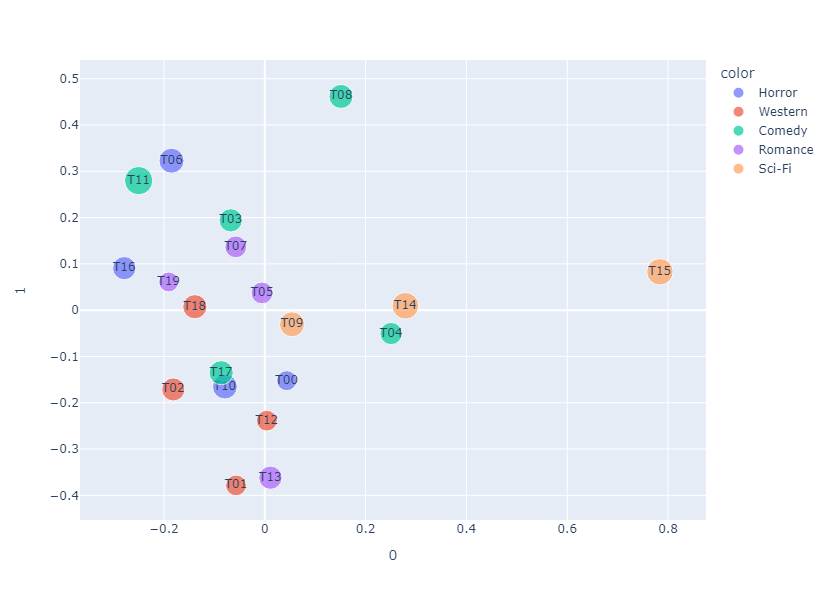

In [59]:
px.scatter(PHI_COMPS.reset_index(), 0, 1, 
           size='mean_doc_weight', 
           color=TOPICS.genre, 
           text='topic_id', hover_name=TOPICS.top_terms, height=600, width=700)

## Sentiment Analysis

In [60]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [61]:
SALEX = pd.read_csv("./Data/salex_nrc.csv").set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

In [62]:
VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
VOCAB_SENT

n         p          i  n_chars max_pos_group max_pos  \
term_str                                                               
good         627  0.001091   9.840248        4            JJ      JJ   
harry        624  0.001086   9.847168        5            NN     NNP   
quail        550  0.000957  10.029282        5            NN     NNP   
interior     491  0.000854  10.192991        8            NN     NNP   
gun          316  0.000550  10.828789        3            NN      NN   
...          ...       ...        ...      ...           ...     ...   
woeful         1  0.000002  19.132570        6            JJ      JJ   
diplomatic     1  0.000002  19.132570       10            JJ      JJ   
dominate       1  0.000002  19.132570        8            VB      VB   
instruct       1  0.000002  19.132570        8            VB      VB   
indignation    1  0.000002  19.132570       11            NN      NN   

               p_stem  stop        DFIDF  anger  anticipation  disgust  fear  \
term_str                                                                       
good             good     0  1260.690786      0             1        0     0   
harry           harri     0   522.716702      1             0        0     0   
quail           quail     0   580.266206      0             0        0     1   
interior     interior     0   981.983783      0             0        1     0   
gun               gun     0   770.521749      1             0        0     1   
...               ...   ...          ...    ...           ...      ...   ...   
woeful         woeful     0    11.533330      0             0        0     0   
diplomatic   diplomat     0    11.533330      0             0        0     0   
dominate        domin     0    11.533330      1             0        0     1   
instruct     instruct     0    11.533330      0             0        0     0   
indignation    indign     0    11.533330      1             0        1     0   

             joy  negative  positive  sadness  surprise  trust  sentiment  
term_str                                                                   
good           1         0         1        0         1      1          1  
harry          0         1         0        1         0      0         -1  
quail          0         1         0        0         0      0         -1  
interior       0         0         1        0         0      1          1  
gun            0         1         0        0         0      0         -1  
...          ...       ...       ...      ...       ...    ...        ...  
woeful         0         1         0        1         0      0         -1  
diplomatic     0         0         1        0         0      1          1  
dominate       0         1         1        0         0      0          0  
instruct       0         0         1        0         0      1          1  
indignation    0         1         0        0         0      0         -1  

[2096 rows x 20 columns]

In [63]:
BOW_SENT = BOW.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
BOW_SENT

n     tfidf max_pos  anger  anticipation  \
script_id page_num term_str                                              
101       1        dirty      1  0.245424      NN    0.0           0.0   
                   food       2  0.377066      NN    0.0           0.0   
                   gentleman  1  0.316049      NN    0.0           0.0   
                   gorgeous   1  0.316049      JJ    0.0           0.0   
                   interior   4  0.493149     NNP    0.0           0.0   
...                          ..       ...     ...    ...           ...   
505       121      miracle    1  0.639169      NN    0.0           1.0   
                   reverend   2  0.920838     NNP    0.0           0.0   
                   sadness    1  0.538095      NN    0.0           0.0   
                   steady     1  0.484174      JJ    0.0           0.0   
          122      mystery    1  4.766665      NN    0.0           1.0   

                              disgust  fear  joy  sadness  surprise  trust  \
script_id page_num term_str                                                  
101       1        dirty          1.0   0.0  0.0      0.0       0.0    0.0   
                   food           0.0   0.0  1.0      0.0       0.0    1.0   
                   gentleman      0.0   0.0  0.0      0.0       0.0    1.0   
                   gorgeous       0.0   0.0  1.0      0.0       0.0    0.0   
                   interior       1.0   0.0  0.0      0.0       0.0    1.0   
...                               ...   ...  ...      ...       ...    ...   
505       121      miracle        0.0   0.0  1.0      0.0       1.0    1.0   
                   reverend       0.0   0.0  1.0      0.0       0.0    0.0   
                   sadness        0.0   0.0  0.0      1.0       0.0    1.0   
                   steady         0.0   0.0  0.0      0.0       1.0    1.0   
          122      mystery        0.0   0.0  0.0      0.0       1.0    0.0   

                              sentiment  
script_id page_num term_str              
101       1        dirty           -1.0  
                   food             1.0  
                   gentleman        1.0  
                   gorgeous         1.0  
                   interior         1.0  
...                                 ...  
505       121      miracle          1.0  
                   reverend         1.0  
                   sadness         -1.0  
                   steady           0.0  
          122      mystery          0.0  

[22895 rows x 12 columns]

In [64]:
DOC_SENT = pd.merge(BOW_SENT.reset_index().groupby('script_id')['sentiment'].mean(), 
         LIB[['script_id', 'title', 'genre']], on="script_id").sort_values('sentiment')
DOC_SENT

script_id  sentiment                          title    genre
13        305  -0.414406                        Tremors   Horror
10        302  -0.383085                      Evil Dead   Horror
9         301  -0.302502                Day of the Dead   Horror
8         205  -0.242563                   Total Recall   Sci-Fi
17        404  -0.153380                Dumb and Dumber   Comedy
1         102  -0.139344                      True Grit  Western
7         204  -0.105613  Star Wars: Return of the Jedi   Sci-Fi
15        402  -0.096314                   Analyze That   Comedy
12        304  -0.089900                      Insidious   Horror
11        303  -0.088083                Friday the 13th   Horror
3         104  -0.070922                The Book of Eli  Western
2         103  -0.070356                 Wild Wild West  Western
20        502  -0.063677                     Angel Eyes  Romance
0         101  -0.050813                    El Mariachi  Western
6         203  -0.050123              Starship Troopers   Sci-Fi
4         201  -0.021714                   Blade Runner   Sci-Fi
22        504   0.009165         The Fault in Our Stars  Romance
16        403   0.025916               Death To Smoochy   Comedy
5         202   0.032730                Minority Report   Sci-Fi
19        501   0.066098                          Amour  Romance
18        405   0.106952         She's Out of My League   Comedy
21        503   0.150000                     Crazy Love  Romance
14        401   0.196009             500 Days of Summer   Comedy
23        505   0.202103             A Walk to Remember  Romance

In [65]:
fault_pages = BOW_SENT.reset_index()[BOW_SENT.reset_index()['script_id'] == 504]\
    .groupby('page_num')[emo_cols].mean()

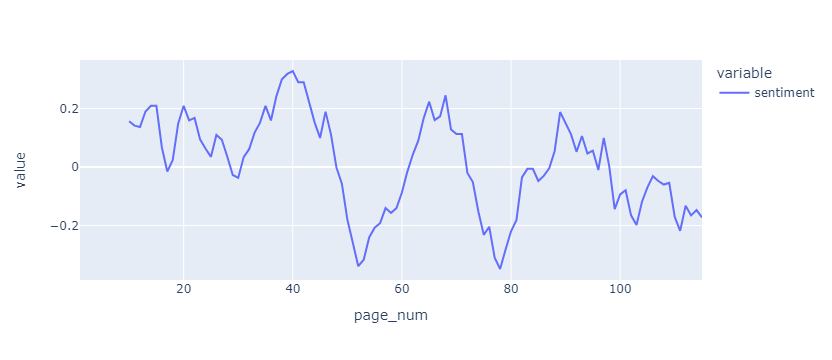

In [66]:
px.line(fault_pages[['sentiment']].rolling(10).mean())

## Word2vec

In [67]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [68]:
docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str']).groupby(['script_id', 'page_num']).term_str\
    .apply(lambda  x:  x.tolist()).reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [69]:
vocab = Dictionary(docs)

In [70]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [71]:
model.wv.vectors

array([[-0.07428427,  0.07733846,  0.1357832 , ...,  0.16474085,
        -0.00347966,  0.10486815],
       [ 0.05882332,  0.10982963, -0.07447826, ..., -0.2883339 ,
        -0.22458418, -0.316004  ],
       [ 0.09830043, -0.62554914,  0.01265926, ..., -0.19465883,
        -0.4643055 , -0.38873667],
       ...,
       [-0.05920415, -0.15137328, -0.06005245, ...,  0.04774761,
        -0.00728389,  0.02384482],
       [-0.03317733, -0.09053212, -0.0226724 , ..., -0.00788303,
         0.04871773,  0.04186131],
       [-0.01563023, -0.05639673,  0.04637183, ..., -0.11379297,
        -0.15033816, -0.05560999]], dtype=float32)

In [72]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [73]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [74]:
WV

0         1         2         3         4         5    \
term_str                                                                
          -0.074284  0.077338  0.135783 -0.038828 -0.384466 -0.304510   
the        0.058823  0.109830 -0.074478 -0.146527 -0.114035 -0.110940   
a          0.098300 -0.625549  0.012659 -0.466814 -0.151991 -0.070457   
and       -0.037684  0.032810  0.179986  0.025947  0.152023  0.022664   
to        -0.027180 -0.063829 -0.213520  0.472953  0.383450  0.112818   
...             ...       ...       ...       ...       ...       ...   
shoulders  0.032887 -0.127733  0.001788  0.022526  0.007819 -0.031587   
spot      -0.013109 -0.073266 -0.003066 -0.077533 -0.003144 -0.084902   
ear        0.017567 -0.120078 -0.041771  0.006768 -0.017400 -0.053175   
plays     -0.021638 -0.060535  0.029192 -0.032648 -0.009704 -0.042143   
turned    -0.059204 -0.151373 -0.060052 -0.027666 -0.021282 -0.109148   

                6         7         8         9    ...       236       237  \
term_str                                           ...                       
          -0.398096 -0.158567  0.041597 -0.107927  ...  0.012156  0.017973   
the       -0.311355 -0.498391 -0.230108 -0.273942  ... -0.319868  0.253619   
a         -0.494629 -0.666559 -0.284084 -0.203199  ... -0.144719  0.263780   
and       -0.335326 -0.215504 -0.075876 -0.011623  ... -0.340190  0.143856   
to        -0.416296 -0.013150  0.172996  0.494337  ... -0.325862  0.045718   
...             ...       ...       ...       ...  ...       ...       ...   
shoulders -0.254497 -0.136259 -0.062130 -0.054723  ... -0.134796  0.153763   
spot      -0.127504 -0.040764 -0.035811 -0.097169  ... -0.194786  0.127484   
ear       -0.237244 -0.065089 -0.042121 -0.077584  ... -0.135600  0.104739   
plays     -0.123285 -0.164219 -0.110784 -0.070047  ... -0.172064  0.163033   
turned    -0.168428 -0.073485 -0.062932 -0.048983  ... -0.127190  0.071800   

                238       239       240       241       242       243  \
term_str                                                                
           0.118363 -0.071168 -0.118634  0.005816 -0.041388  0.164741   
the       -0.307733 -0.127515  0.054710  0.027665 -0.503774 -0.288334   
a         -0.348545  0.175112  0.130749 -0.199195 -0.153962 -0.194659   
and       -0.088958  0.077246  0.094600  0.073935 -0.161181 -0.159812   
to        -0.059768  0.378364  0.041904  0.469057 -0.315225  0.068311   
...             ...       ...       ...       ...       ...       ...   
shoulders  0.034212 -0.046330 -0.045271 -0.112030  0.098393 -0.030519   
spot       0.060905  0.018216 -0.080838 -0.109766  0.039431 -0.040761   
ear        0.032123 -0.070329 -0.061800 -0.132392  0.104984 -0.013621   
plays      0.020612 -0.086936 -0.071071 -0.138919  0.030909 -0.067679   
turned    -0.005089 -0.009021 -0.047985 -0.042257  0.049678  0.047748   

                244       245  
term_str                       
          -0.003480  0.104868  
the       -0.224584 -0.316004  
a         -0.464305 -0.388737  
and       -0.268450 -0.062855  
to         0.030663  0.343546  
...             ...       ...  
shoulders -0.083151 -0.005454  
spot       0.027006  0.013533  
ear       -0.004805  0.054586  
plays     -0.064859 -0.049472  
turned    -0.007284  0.023845  

[919 rows x 246 columns]

## tSNE

In [75]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=5001)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [76]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [77]:
TSNE

x          y
term_str                       
            0.318581  -6.230122
the       -28.784475  12.874655
a         -12.355378  -3.827046
and       -31.405704  -2.107871
to          3.012207  15.190316
...              ...        ...
shoulders -20.251959  -5.370482
spot       -4.310909   6.183477
ear       -17.453976  -8.815918
plays     -17.586689   3.555820
turned      6.698467   3.200108

[919 rows x 2 columns]

In [78]:
X = TSNE.join(VOCAB, how='left')

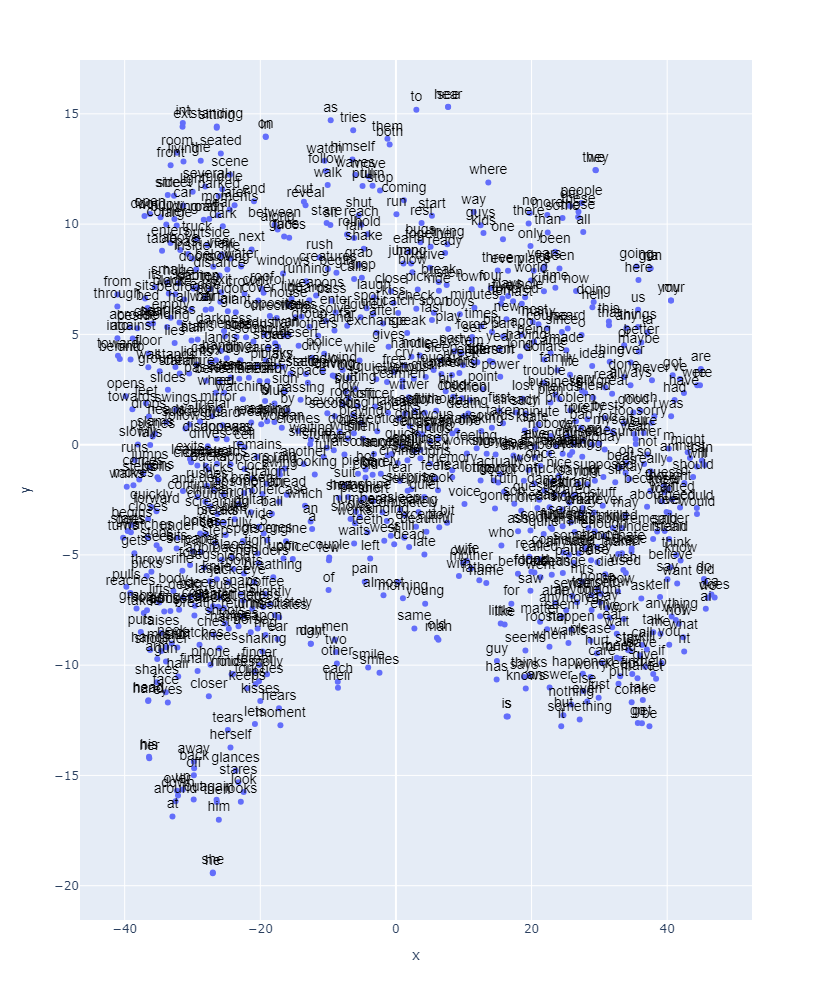

In [79]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           #color='pos_max', 
           hover_name='term_str',          
           #size='tfidf_sum',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

![](./Images/tsne_zoom.png)

## Riffs

### Sentiment by Genre

In [80]:
page_sents = BOW_SENT.groupby(['script_id', 'page_num'])['sentiment'].mean().reset_index()

In [81]:
def scale_pages(script_id, page_sents=page_sents):
    temp = page_sents[page_sents.script_id == script_id][['page_num', 'sentiment']]
    temp.page_num /= max(temp.page_num)
    temp.page_num *= 100
    temp.page_num = temp.page_num.round(2)
    return temp

In [82]:
def interpolate_and_average(dataframes, common_x):
    interpolated_dfs = []
    for df in dataframes:
        df_interpolated = pd.DataFrame({'page_num': common_x})
        df_interpolated['sentiment'] = np.interp(common_x, df['page_num'], df['sentiment'])
        interpolated_dfs.append(df_interpolated)
    average_sentiment = sum(df['sentiment'] for df in interpolated_dfs) / len(interpolated_dfs)
    return interpolated_dfs, average_sentiment

In [83]:
common_x = np.round(np.linspace(0, 100, 1001), 2)
_, average_sentiment_western = interpolate_and_average([scale_pages(x) for x in range(101, 105)], common_x)
_, average_sentiment_scifi = interpolate_and_average([scale_pages(x) for x in range(201, 206)], common_x)
_, average_sentiment_horror = interpolate_and_average([scale_pages(x) for x in range(301, 306)], common_x)
_, average_sentiment_comedy = interpolate_and_average([scale_pages(x) for x in range(401, 406)], common_x)
_, average_sentiment_romance = interpolate_and_average([scale_pages(x) for x in range(501, 506)], common_x)

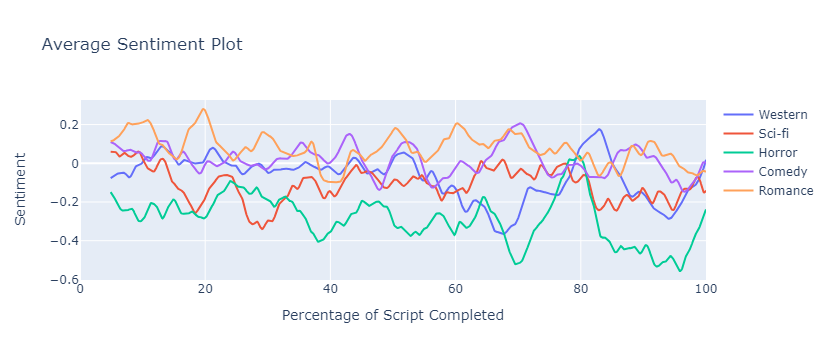

In [84]:
fig = go.Figure()
window=50

fig.add_trace(go.Scatter(x=common_x, y=average_sentiment_western.rolling(window).mean(), 
                         mode='lines', name='Western'))
fig.add_trace(go.Scatter(x=common_x, y=average_sentiment_scifi.rolling(window).mean(), 
                         mode='lines', name='Sci-fi'))
fig.add_trace(go.Scatter(x=common_x, y=average_sentiment_horror.rolling(window).mean(), 
                         mode='lines', name='Horror'))
fig.add_trace(go.Scatter(x=common_x, y=average_sentiment_comedy.rolling(window).mean(), 
                         mode='lines', name='Comedy'))
fig.add_trace(go.Scatter(x=common_x, y=average_sentiment_romance.rolling(window).mean(), 
                         mode='lines', name='Romance'))

fig.update_layout(title='Average Sentiment Plot', xaxis_title='Percentage of Script Completed', yaxis_title='Sentiment')
fig.show()

### Clustering

In [85]:
sig_1000 = set(VOCAB.sort_values('DFIDF', ascending=False).head(1000).index)

In [86]:
valid_pos_terms = set(VOCAB[VOCAB.max_pos.isin(['NN', 'NNS', 'VB', 'VBD', 'VBG', 
                                                                       'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 
                                                                       'JJS', 'RB', 'RBR', 'RBS'])].index)

In [87]:
valid_cols = list(sig_1000.intersection(valid_pos_terms))

In [88]:
TFIDF_subset = TFIDF[valid_cols]

In [89]:
TFIDF_subset = TFIDF_subset.groupby('script_id').mean()

In [90]:
L0 = TFIDF_subset.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF_subset.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF_subset.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [91]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([TFIDF_subset.index.tolist(), 
                                                       TFIDF_subset.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [92]:
PAIRS['cityblock'] = pdist(TFIDF_subset, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF_subset, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF_subset, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [93]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.title.values + ": " + LIB.genre.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

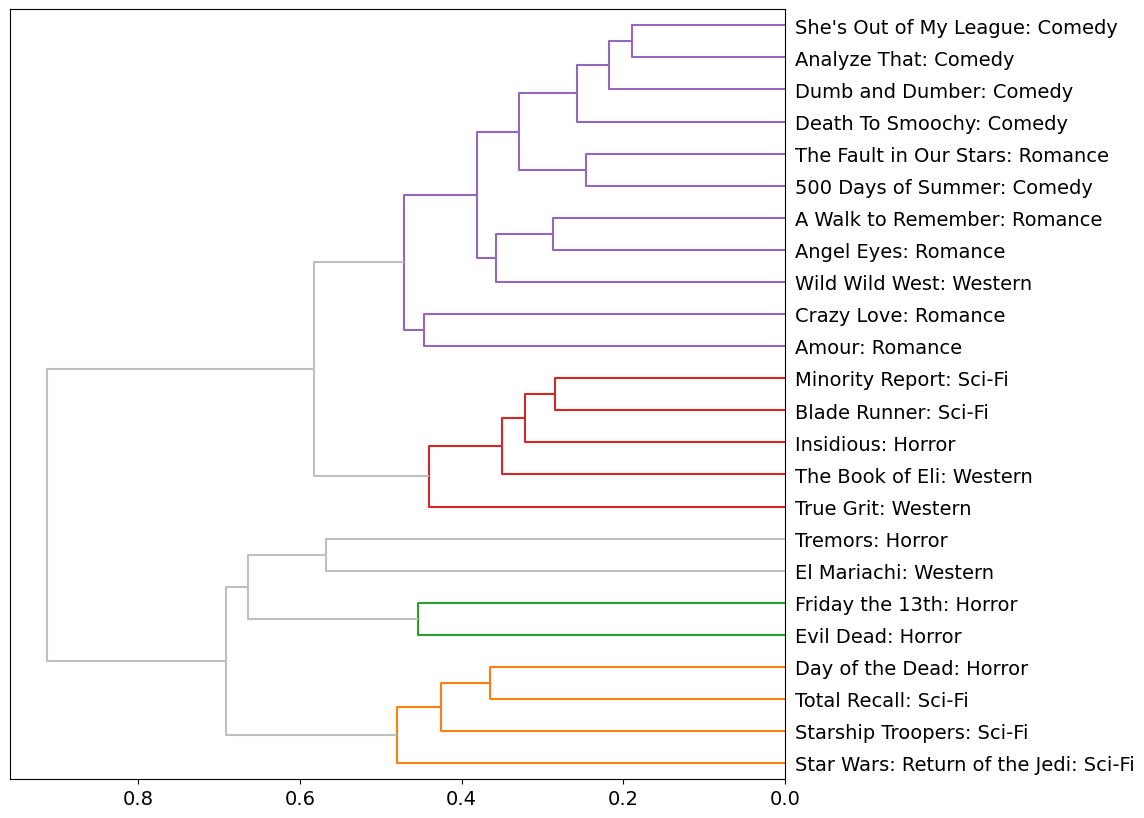

In [94]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=.5)

### Correlations

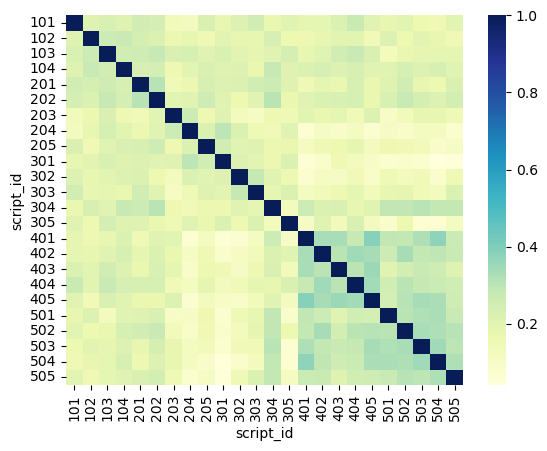

In [95]:
CORR_MATRIX = TFIDF_subset.T.corr('kendall')
heatmap = sns.heatmap(CORR_MATRIX, cmap="YlGnBu")
heatmap;

## Export Tables

In [96]:
# LIB.to_csv('LIB.csv', header=True, sep='|')
# CORPUS.to_csv('CORPUS.csv', header=True, sep='|')
# VOCAB.to_csv('VOCAB.csv', header=True, sep='|')

# BOW.to_csv('BOW.csv', header=True, sep='|')
# DTCM.to_csv('DTM.csv', header=True, sep='|')
# TFIDF.to_csv('TFIDF.csv', header=True, sep='|')
# TFIDF_L2.to_csv('TFIDF_L2.csv', header=True, sep='|')

# C.to_csv('PCA_COMPONENTS.csv', header=True, sep='|')
# D.to_csv('PCA_DCM.csv', header=True, sep='|')
# L.to_csv('PCA_LOADINGS.csv', header=True, sep='|')

# TOPICS.to_csv('LDA_TOPICS.csv', header=True, sep='|')
# THETA.to_csv('LDA_THETA.csv', header=True, sep='|')
# PHI.to_csv('LDA_PHI.csv', header=True, sep='|')

# VOCAB_SENT.to_csv('VOCAB_SENT.csv', header=True, sep='|')
# BOW_SENT.to_csv('BOW_SENT.csv', header=True, sep='|')
# DOC_SENT.to_csv('DOC_SENT.csv', header=True, sep='|')

# WV.to_csv('VOCAB_W2V.csv', header=True, sep='|')